In [15]:
from fastbook import *

In [16]:
urls = search_images_ddg('teddy photos', max_images=1)
len(urls), urls[0]

(1,
 'https://i.pinimg.com/originals/6d/2b/3e/6d2b3ee811a8092cd46b14b3057a263d.jpg')

In [17]:
dest = Path('teddy.jpg')
if not dest.exists(): download_url(urls[0], dest)

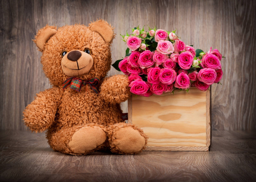

In [18]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [19]:
import requests

In [38]:
import requests
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from io import BytesIO

bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')

if not path.exists():
    path.mkdir()

for o in bear_types:
    dest = path / o
    dest.mkdir(exist_ok=True)
    
    # Assuming you have a function 'search_images_ddg' to search for images
    results = search_images_ddg(f'{o} bear', max_images=50)
    
    # Debugging: Check the results
    if results is None:
        print(f"No results for {o} bear")
        continue
    
    print(f"Results for {o} bear: {results}")
    print(f"Saving images to: {dest}")
    
    for i, url in enumerate(results):
        # Verify URL is an image
        try:
            response = requests.head(url, allow_redirects=True)
            content_type = response.headers.get('Content-Type', '')
        except Exception as e:
            print(f"Failed to retrieve headers for {url}: {e}")
            continue

        if 'image' not in content_type:
            print(f"Skipping non-image URL: {url}")
            continue
        
        # Pobierz obraz z URL
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            
            # Załaduj obraz do pamięci
            img = Image.open(BytesIO(response.content))
            
            # Wykonaj kopię obrazu przed weryfikacją
            img_copy = img.copy()
            
            # Weryfikacja poprawności obrazu
            img.verify()

            # Zapisz kopię obrazu (bo img po verify jest nieużyteczne)
            dest2 = dest / f"{i}.jpg"
            print(f"Saving {url} as {dest2}")
            img_copy.save(dest2)
            
        except (requests.RequestException, UnidentifiedImageError, IOError) as e:
            print(f"Failed to download or verify image from {url}: {e}")
            continue


Results for grizzly bear: ['http://images2.fanpop.com/image/photos/13100000/Grizzly-Bears-animals-13128534-1024-768.jpg', 'https://st.depositphotos.com/1746939/1285/i/950/depositphotos_12855514-stock-photo-grizzly-bear.jpg', 'https://www.environews.tv/wp/wp-content/uploads/2016/03/Yellowstone-Grizzly-Bear-4.jpg', 'http://grizzlybearwatching.com/wp-content/uploads/2013/03/July-5-yawn.jpg', 'http://www1.cs.columbia.edu/~sedwards/photos/kyle200604/20060412-7108%20Grizzly%20bear.jpg']
Saving images to: bears/grizzly
Saving http://images2.fanpop.com/image/photos/13100000/Grizzly-Bears-animals-13128534-1024-768.jpg as bears/grizzly/0.jpg
Saving https://st.depositphotos.com/1746939/1285/i/950/depositphotos_12855514-stock-photo-grizzly-bear.jpg as bears/grizzly/1.jpg
Saving https://www.environews.tv/wp/wp-content/uploads/2016/03/Yellowstone-Grizzly-Bear-4.jpg as bears/grizzly/2.jpg
Saving http://grizzlybearwatching.com/wp-content/uploads/2013/03/July-5-yawn.jpg as bears/grizzly/3.jpg
Saving ht

In [ ]:
fns = get_image_files(path)
fns

(#135) [Path('bears/black/35.jpg'),Path('bears/black/9.jpg'),Path('bears/black/16.jpg'),Path('bears/black/32.jpg'),Path('bears/black/17.jpg'),Path('bears/black/47.jpg'),Path('bears/black/48.jpg'),Path('bears/black/3.jpg'),Path('bears/black/11.jpg'),Path('bears/black/4.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#4) [Path('bears/black/41.jpg'),Path('bears/black/24.jpg'),Path('bears/black/31.jpg'),Path('bears/grizzly/12.jpg')]

In [ ]:
failed.map(Path.unlink)

(#4) [None,None,None,None]

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [21]:
dls = bears.dataloaders(path, bs=5)

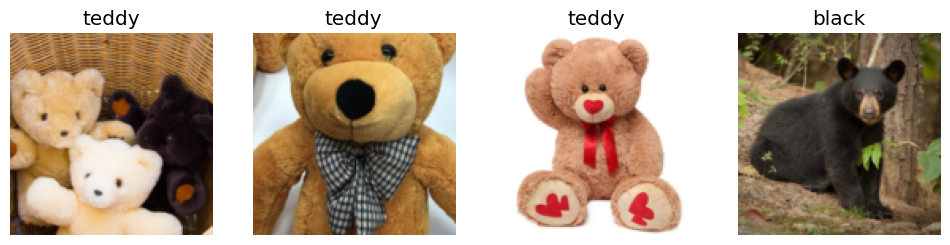

In [22]:
dls.train.show_batch(max_n=4, nrows=1)


In [23]:
print(len(dls.train_ds))


118


In [24]:
batch = dls.train.one_batch()
print(len(batch[0]))


5


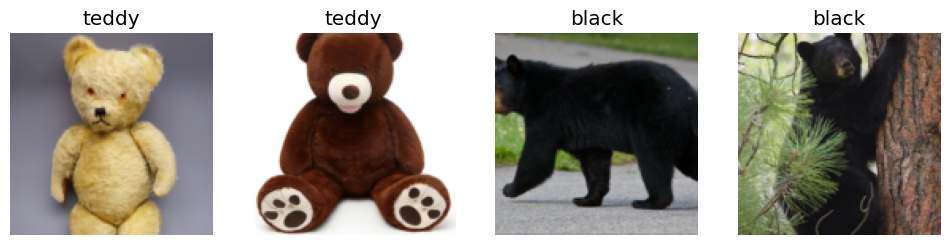

In [25]:
dls.train.show_batch(max_n=4, nrows=1)


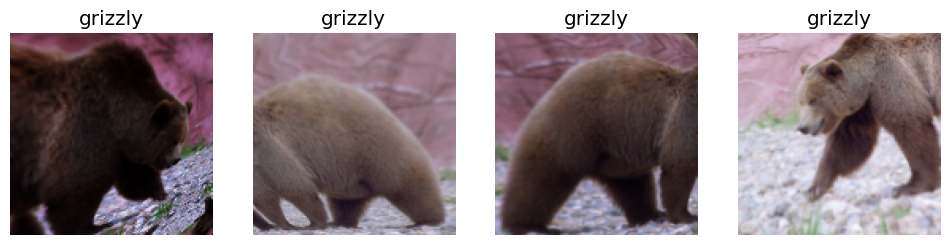

In [30]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) # type: ignore
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [34]:
from PIL import Image, UnidentifiedImageError
from pathlib import Path

for image_file in path.rglob('*'):  # rglob('*') znajdzie wszystkie pliki
    if image_file.is_file():  # Sprawdzenie, czy to plik, a nie katalog
        try:
            img = Image.open(image_file)
            img.verify()  # Weryfikacja, czy to poprawny obrazek
        except (IOError, SyntaxError, UnidentifiedImageError) as e:
            print(f"Usuwanie uszkodzonego obrazka: {image_file}")
            image_file.unlink()  # Usuwanie uszkodzonego pliku
    else:
        print(f"Pomijanie katalogu: {image_file}")


Pomijanie katalogu: bears/black
Pomijanie katalogu: bears/teddy
Pomijanie katalogu: bears/grizzly
Usuwanie uszkodzonego obrazka: bears/grizzly/0.jpg


In [35]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 41, in fetch
    data = next(self.dataset_iter)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastcore/basics.py", line 234, in chunked
    res = list(itertools.islice(it, chunk_sz))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/data/load.py", line 168, in do_item
    try: return self.after_item(self.create_item(s))
                                ^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/data/load.py", line 175, in create_item
    if self.indexed: return self.dataset[s or 0]
                            ~~~~~~~~~~~~^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/data/core.py", line 447, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
                 ~~^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/data/core.py", line 406, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/data/core.py", line 366, in _after_item
    def _after_item(self, o): return self.tfms(o)
                                     ^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
        ^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
                                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
                       ^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/vision/core.py", line 125, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/fastai/vision/core.py", line 98, in load_image
    im = Image.open(fn)
         ^^^^^^^^^^^^^^
  File "/home/mzums/miniconda3/envs/ml/lib/python3.12/site-packages/PIL/Image.py", line 3277, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/mzums/programming/machine_learning/bears/bears/grizzly/0.jpg'
